In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core and lithosphere with tapered ensembles as prior"
nb_name = "nb_case_lith_synthetic"

In [2]:
shc_g = 60
shc_grid = 60

lith = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens", sat_height = 350)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

#lith.condtab(normsize=10000, quantiles = 1000, 
#             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


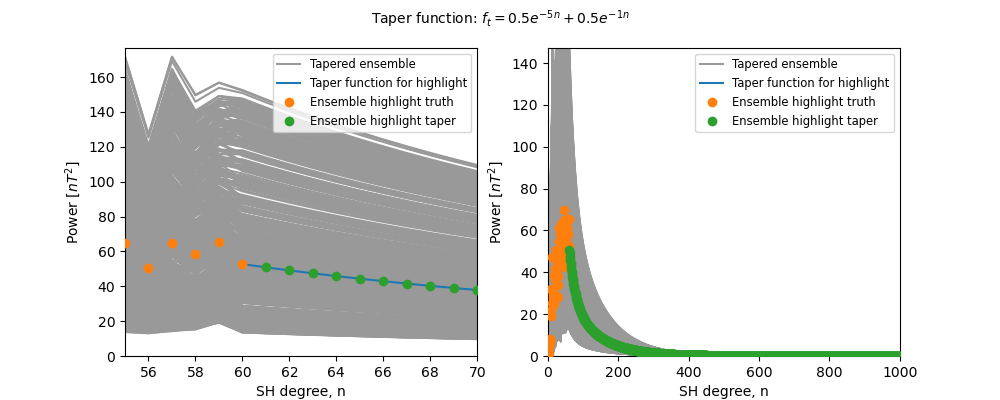

In [22]:
lith.cov_model_taper(r_at = lith.a, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)

#lith.cov_model(r_at = lith.a)

In [17]:
C_e_const = 0.01

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("ABC")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [4]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = s_source.a)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.a, grid_in, calc_sph_d = False)

s_source.generate_map()

In [9]:
lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 10, zero_nugget = True)

____semi-variogram setup___

Number of data used: 54478193
Max data distance: 19996.320 km
Lag length chosen: 10.0 km
Number of lags: 1999
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


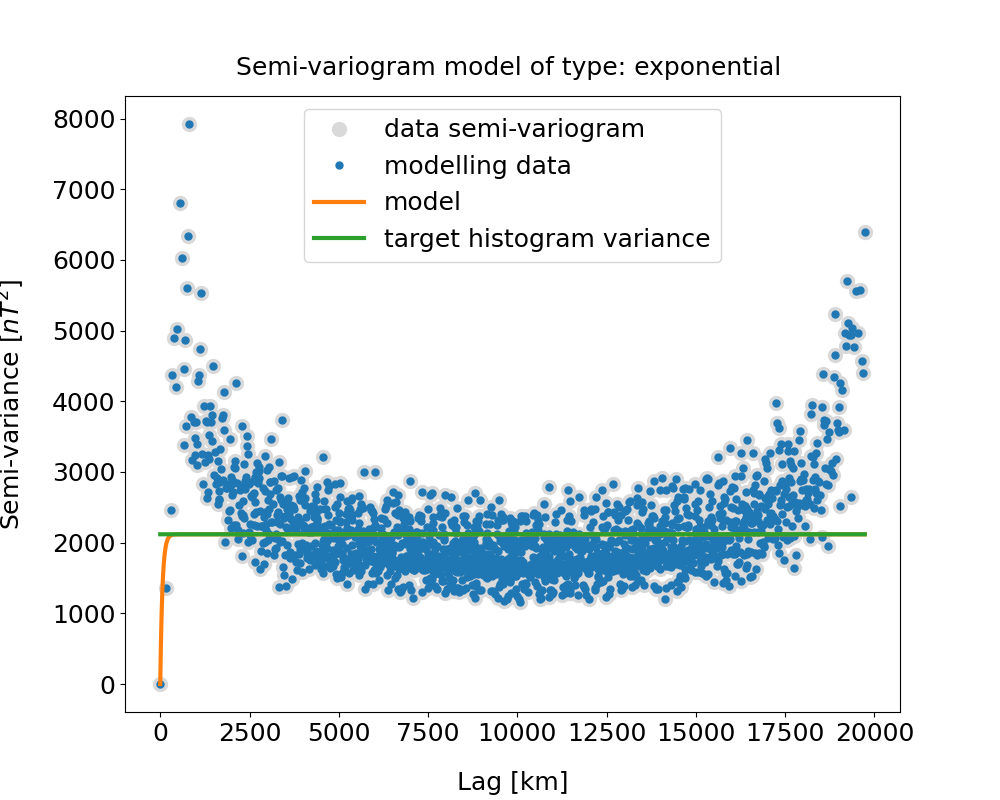

In [10]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(lith.lags,lith.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(lith.lags_model,lith.pics_model,'.',markersize=10,label='modelling data')
plt.plot(lith.lags_sv_curve,lith.sv_curve,color='C1',linewidth = 3,label='model')
plt.plot(lith.lags_sv_curve,np.ones(lith.lags_sv_curve.shape)*lith.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % lith.model_names[lith.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [23]:
print(lith)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Synthetic core and lithosphere with tapered ensembles as prior
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
N_SH_secondary:        None
sim_type:              lith_ens
grid_zero:             (61,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (61,), Max/Min: 0.05 / 0.00
grid_shape:            (2,), Max/Min: 121.00 / 61.00
grid_w:                (7381,), Max/Min: 0.05 / 0.00
grid_radial:           (7381,), Max/Min: 6371.20 / 6371.20
grid_theta:            (7381,), Max/Min: 177.76 / 2.24
grid_phi:              (7381,), Max/Min: 357.02 / 0.00
grid_N:                7381
grid_nmax:             60
r_grid:                6371.2
grid:                  (7381, 2)
sph_d:                 (7381, 7381)
lon:     

In [88]:
crust_gemma = np.load("mikkel_tools/models_grid/crust_gemma_p05.npy").reshape(360,720)
crust_gemma = np.hstack((crust_gemma[:,360:],crust_gemma[:,:360])).reshape(-1,)
crust_gemma_err = np.load("mikkel_tools/models_grid/crust_gemma_err_p05.npy").reshape(360,720)
crust_gemma_err = np.hstack((crust_gemma_err[:,360:],crust_gemma_err[:,:360])).reshape(-1,)

In [89]:
gemma_phi, gemma_theta = np.meshgrid(np.arange(0,360,0.5), np.arange(0,180,0.5))
gemma_phi = gemma_phi.reshape(-1,)
gemma_theta = gemma_theta.reshape(-1,)

In [108]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

crust_gemma_itp = mt_util.interpolate_grid(gemma_theta, lith.grid_theta, gemma_phi, lith.grid_phi, crust_gemma, 
                                        method_int = "nearest")

In [159]:
test_C = lith.target_var - lith.sv_lut[:5,:5]
print(test_C)

[[2118.26599918 1716.20670969 1390.68407077 1127.25073839  914.13311675]
 [1716.20670969 2118.26599918 1716.20670969 1390.68407077 1127.25073839]
 [1390.68407077 1716.20670969 2118.26599918 1716.20670969 1390.68407077]
 [1127.25073839 1390.68407077 1716.20670969 2118.26599918 1716.20670969]
 [ 914.13311675 1127.25073839 1390.68407077 1716.20670969 2118.26599918]]


In [160]:
test_sphd = lith.sph_d[:5,:5]
print(test_sphd)

[[ 0.         12.93183088 25.85495812 38.76068384 51.64032176]
 [12.93183088  0.         12.93183088 25.85495812 38.76068384]
 [25.85495812 12.93183088  0.         12.93183088 25.85495812]
 [38.76068384 25.85495812 12.93183088  0.         12.93183088]
 [51.64032176 38.76068384 25.85495812 12.93183088  0.        ]]


In [161]:
test_theta = lith.grid_theta.reshape(61,121)[:5,:5]
print(test_theta)

[[ 2.24040385  2.24040385  2.24040385  2.24040385  2.24040385]
 [ 5.14266166  5.14266166  5.14266166  5.14266166  5.14266166]
 [ 8.06205882  8.06205882  8.06205882  8.06205882  8.06205882]
 [10.9853284  10.9853284  10.9853284  10.9853284  10.9853284 ]
 [13.9100668  13.9100668  13.9100668  13.9100668  13.9100668 ]]


In [162]:
test_diff = np.diff(test_theta,axis=0)
test_diff = np.vstack((test_diff, test_diff[0,:]))
print(test_diff)

[[2.90225781 2.90225781 2.90225781 2.90225781 2.90225781]
 [2.91939715 2.91939715 2.91939715 2.91939715 2.91939715]
 [2.92326958 2.92326958 2.92326958 2.92326958 2.92326958]
 [2.92473839 2.92473839 2.92473839 2.92473839 2.92473839]
 [2.90225781 2.90225781 2.90225781 2.90225781 2.90225781]]


In [163]:
test_diff_norm.reshape(-1,).shape

(7381,)

In [165]:
test_diff_norm = 100*(test_diff-np.mean(test_diff))+1
print(test_diff_norm)

[[-0.21263389 -0.21263389 -0.21263389 -0.21263389 -0.21263389]
 [ 1.50130031  1.50130031  1.50130031  1.50130031  1.50130031]
 [ 1.88854318  1.88854318  1.88854318  1.88854318  1.88854318]
 [ 2.0354243   2.0354243   2.0354243   2.0354243   2.0354243 ]
 [-0.21263389 -0.21263389 -0.21263389 -0.21263389 -0.21263389]]


In [166]:
test_theta_stretch = test_C*test_diff_norm
print(test_theta_stretch)

[[-450.41514755 -364.92371528 -295.70656904 -239.69171381 -194.37568408]
 [2576.54167271 3180.1534104  2576.54167271 2087.83443258 1692.34188787]
 [2626.36691059 3241.13046867 4000.43679582 3241.13046867 2626.36691059]
 [2294.43354308 2830.63214876 3493.20883763 4311.57008477 3493.20883763]
 [-194.37568408 -239.69171381 -295.70656904 -364.92371528 -450.41514755]]


In [138]:
print(test_theta_stretch - test_C)

[[-25.68681147 -20.81130425 -16.8639064  -13.66942452 -11.08508801]
 [  8.60334963  10.61887411   8.60334963   6.97150362   5.65091149]
 [ 12.3568284   15.24923759  18.82170797  15.24923759  12.3568284 ]
 [ 11.67182805  14.39948078  17.77002128  21.93304086  17.77002128]
 [-11.08508801 -13.66942452 -16.8639064  -20.81130425 -25.68681147]]


In [197]:
test_diff = np.diff(lith.grid_theta,axis=0)

In [221]:
test_diff = np.diff(lith.grid_theta,axis=0)
test_diff = np.vstack((test_diff.reshape(-1,1), test_diff[0].reshape(-1,1)))

test_diff_norm = 1*(test_diff-np.mean(test_diff))+1

C_theta_stretch = (lith.target_var - lith.sv_lut)*(test_diff_norm@test_diff_norm.T)

<IPython.core.display.Javascript object>


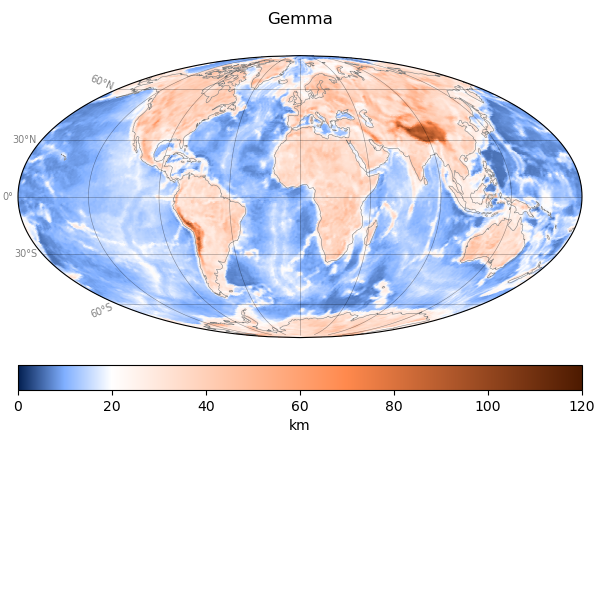

<IPython.core.display.Javascript object>


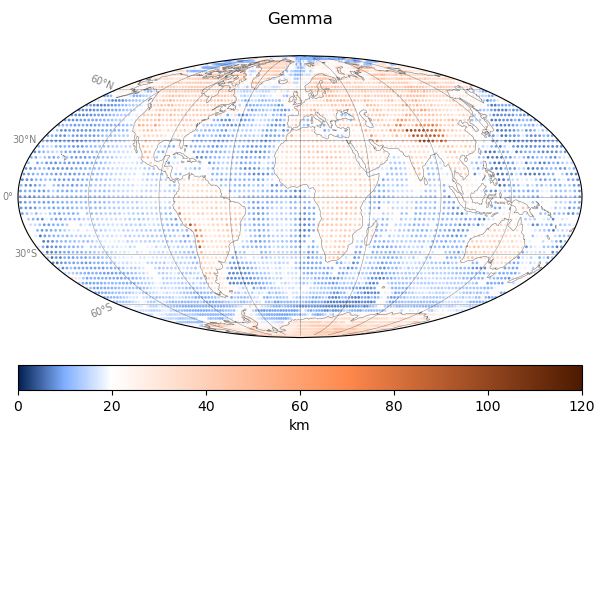

In [109]:
mt_util.plot_global(lat = 90-gemma_theta, lon = gemma_phi, data=crust_gemma, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 20)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=crust_gemma_itp, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 20)

In [56]:
s_source.ensemble_B(s_source.g_prior, nmax = shc_g, r_at = s_source.a, grid_type = "glq")
m_lith_truth = s_source.B_ensemble[:,0].copy()

idx_lowpass = np.abs(m_lith_truth)<3

print(m_lith_truth[idx_lowpass].shape)

(2395,)


In [222]:
# Spectra
#C_mm_in = lith.C_ens_tap
# Semi-variogram
#C_mm_in = lith.target_var-lith.sv_lut
#C_mm_in[:,idx_lowpass] = 0.0
#C_mm_in[idx_lowpass, :] = 0.0
C_mm_in = C_theta_stretch

lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_mm_in)

<IPython.core.display.Javascript object>


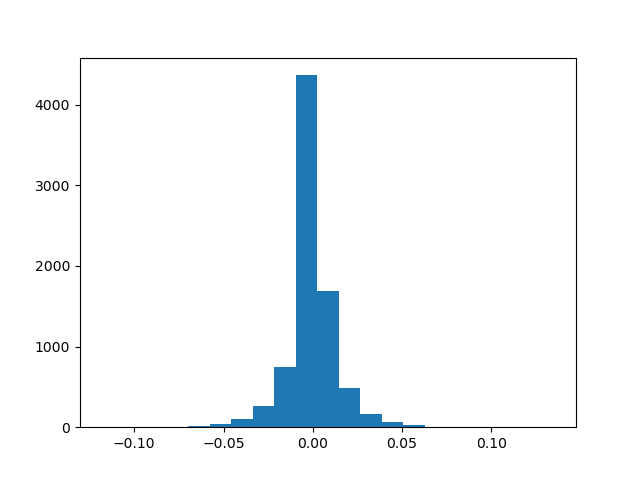

In [223]:
lith.covmod_lsq_equiv(s_sat.data, C_mm_in, lith.G, lith.a)

plt.figure()
plt.hist(lith.lsq_equiv_res,bins=21)
plt.show()

In [224]:
lith.grid_glq(nmax = 256, r_at = lith.a)
lith.ensemble_B(lith.g_equiv_lsq, nmax = shc_g, r_at = lith.a, grid_type = "glq")
m_lsq_lith = lith.B_ensemble[:,0].copy()

s_source.grid_glq(nmax = 256, r_at = s_source.a)
s_source.ensemble_B(s_source.g_prior, nmax = shc_g, r_at = s_source.a, grid_type = "glq")
m_lith_truth = s_source.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


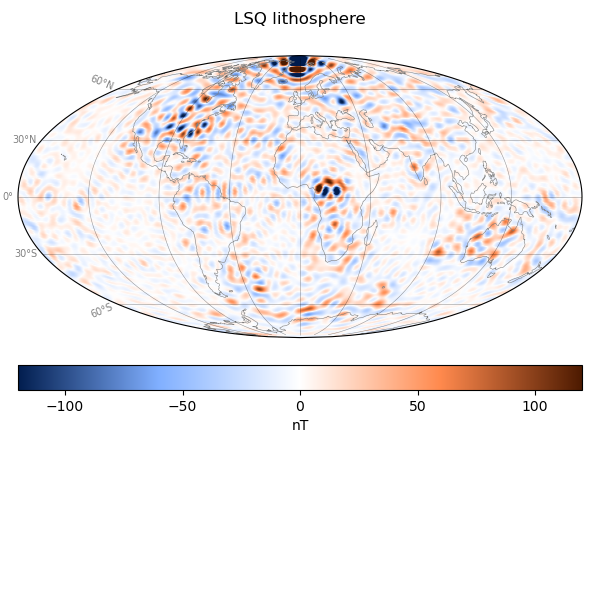

In [225]:
mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lsq_lith, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='LSQ lithosphere', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

lith.grid_glq(nmax = shc_g, r_at = lith.a)
s_source.grid_glq(nmax = shc_g, r_at = s_source.a)

<IPython.core.display.Javascript object>


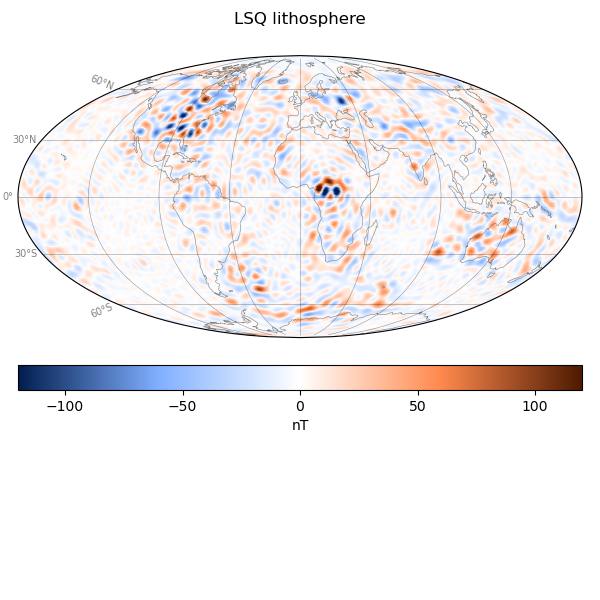

<IPython.core.display.Javascript object>


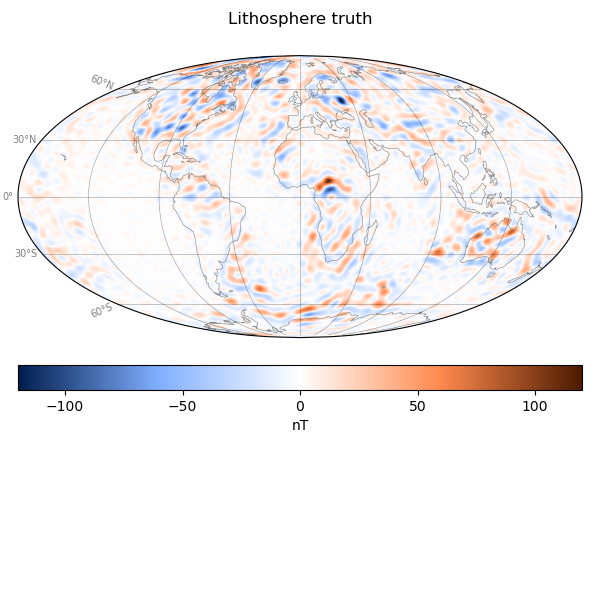

In [146]:
mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lsq_lith, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='LSQ lithosphere', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lith_truth, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Lithosphere truth', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

lith.grid_glq(nmax = shc_g, r_at = lith.a)
s_source.grid_glq(nmax = shc_g, r_at = s_source.a)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 7381/7381, Running error magnitude: 1.4
Run time: 5.022 hours 
Total elapsed time: 5.022 hours 
Variance: 2353.804
Mean: -0.064
Max: 440.152
Min: -423.469
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 7381/7381, Running error magnitude: 1.4
Run time: 4.314 hours 
Total elapsed time: 9.336 hours 
Variance: 2336.710
Mean: -0.385
Max: 409.071
Min: -731.032
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 7381/7381, Running error magnitude: 1.4
Run time: 4.326 hours 
Total elapsed time: 13.662 hours 
Variance: 2010.520
Mean: -0.679
Max: 264.808
Min: -344.501
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 7381/7381, Running error magnitude: 1.4
Run time: 4.385 hours 
Total elapsed time: 18.047 hours 
Variance: 2069.578
Mean: 0.250
Max: 407.826
Min: -393.242
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 7381/7381, Running error magnitude: 1.4
Run time: 4.346 hours 
Total elapsed

<IPython.core.display.Javascript object>


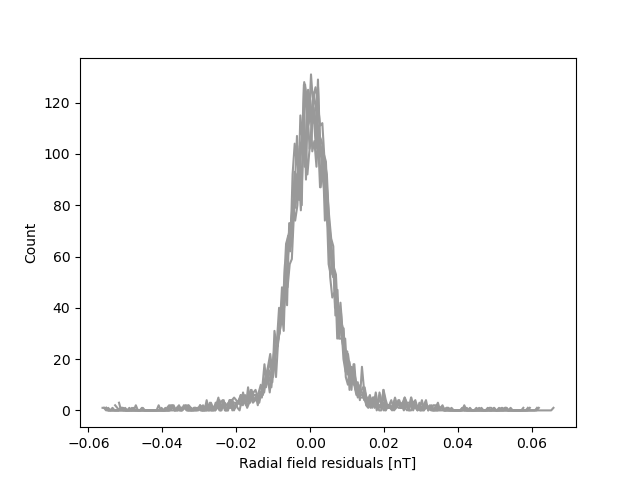

In [10]:
N_sim = 6
lith.target_var = np.max(lith.C_ens_tap)

lith.run_sim(N_sim, lith.grid_N, lith.C_mm_all, lith.C_dd, lith.C_dm_all, lith.G,
        s_sat.data, lith.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [16]:
lith.realization_to_sh_coeff(lith.a, set_nmax = shc_grid)

<IPython.core.display.Javascript object>


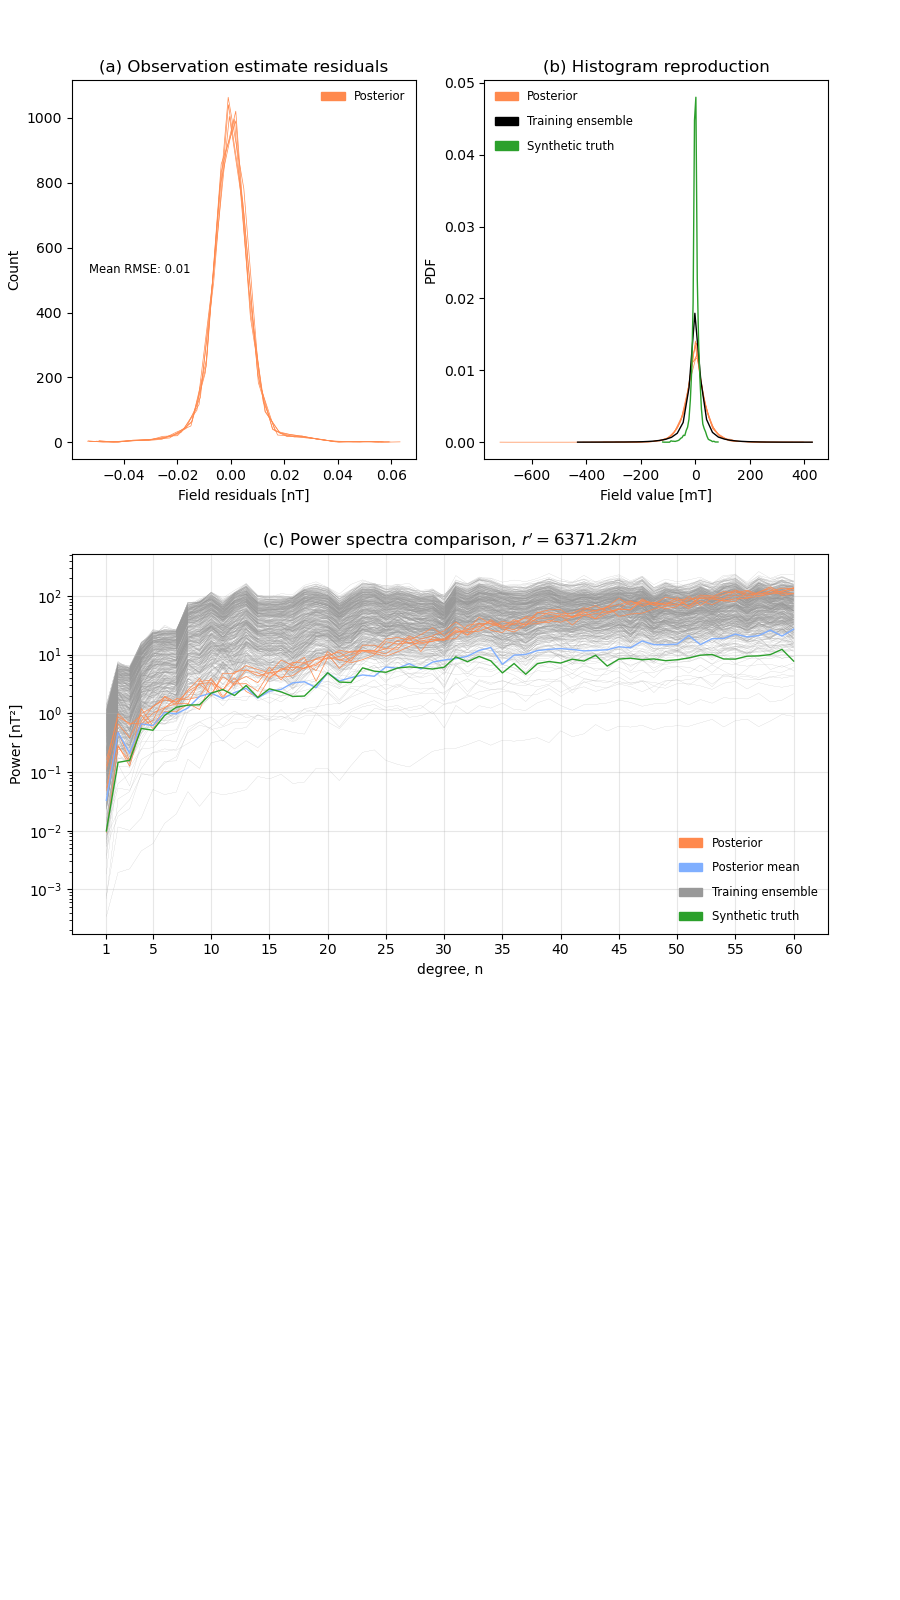

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.a, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = False, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic", save_dpi = 300)

In [23]:
#lith.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [18]:
lith.grid_glq(nmax = 256, r_at = lith.a)

set_nmax = shc_grid

lith.ensemble_B(lith.g_spec, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_eqa = lith.B_ensemble[:,0,:].copy()

lith.ensemble_B(lith.g_spec_mean, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_mean_eqa = lith.B_ensemble[:,0].copy()

lith.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = lith.a, grid_type = "glq")
prior_eqa = lith.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


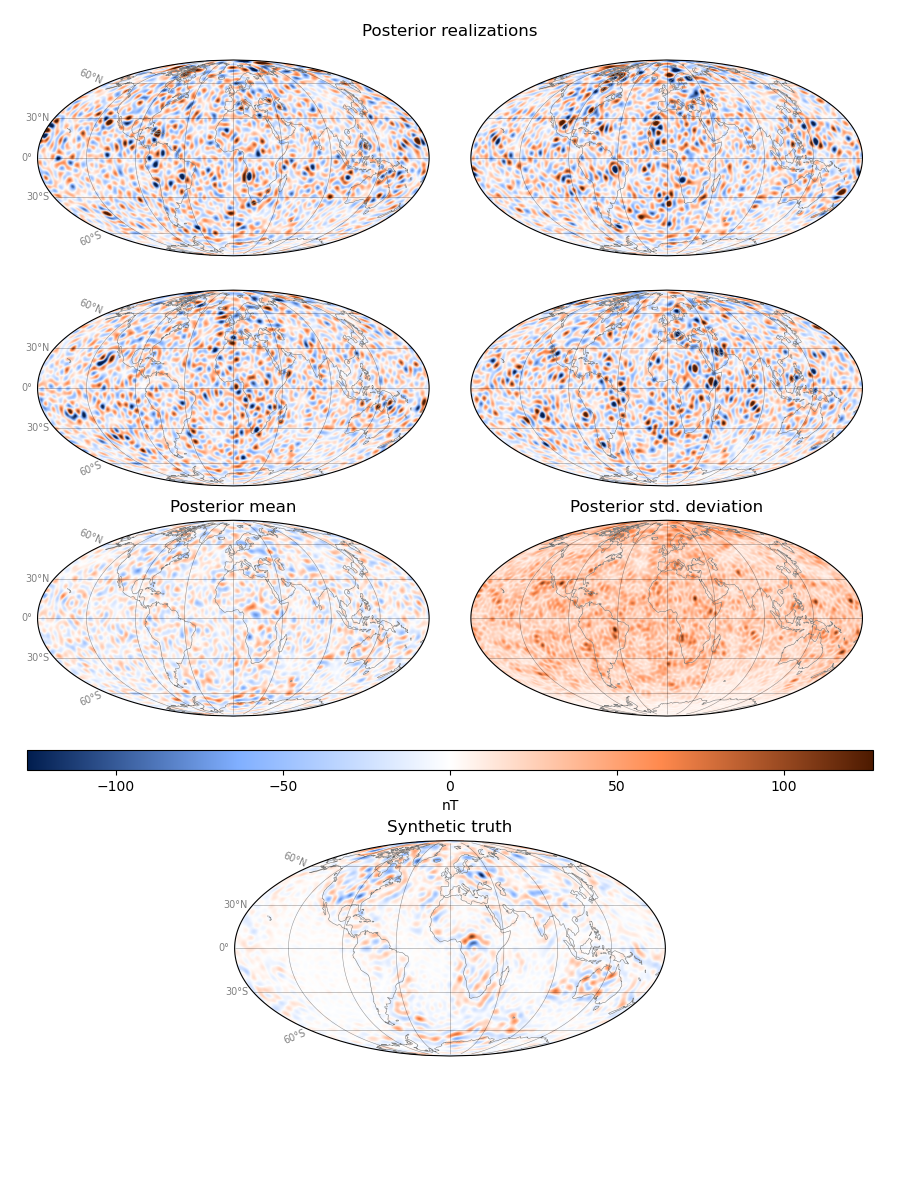

In [19]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(lith.grid_phi, 90-lith.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_lith_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
